In [1]:
# This is made according to the mlpractical course materials in the University of Edinburgh. 
# 参考爱丁堡大学的mlpractical的课程资料写作
# write a nn from zero without any framework
# 不使用任何框架从0写一个神经网络

In [2]:
import numpy as np
DEFAULT_SEED = 1111 # 随机种子

In [3]:
def fprop(inputs, weights, biases):
    print('check shapes of inputs and weights')
    print('inputs', inputs, inputs.shape, sep = '\n')
    print('weights', weights, weights.shape, sep = '\n')
    output = np.dot(inputs, weights.T) + biases
    return output

In [4]:
inputs = np.array([[0., -1., 2.], [-6., 3., 1.]])
weights = np.array([[2., -3., -1.], [-5., 7., 2.]])
biases = np.array([5., -3.])
true_outputs = np.array([[6., -6.], [-17., 50.]])

if not np.allclose(fprop(inputs, weights, biases), true_outputs):
    print('Wrong outputs computed.')
else:
    print('All outputs correct!')

check shapes of inputs and weights
inputs
[[ 0. -1.  2.]
 [-6.  3.  1.]]
(2, 3)
weights
[[ 2. -3. -1.]
 [-5.  7.  2.]]
(2, 3)
All outputs correct!


In [5]:
def error(outputs, targets):
    """Calculates error function given a batch of outputs and targets.
    针对输出和目标值计算损失，这里使用的是均方误差，这里可以做替换
    因为输入是矩阵，可以使用batch输入，所以这里就对做了除法
    """
    return 0.5 * ((outputs - targets)**2).sum() / outputs.shape[0]
    
def error_grad(outputs, targets):
    """Calculates gradient of error function with respect to model outputs.

    Args:
        outputs: Array of model outputs of shape (batch_size, output_dim).
        targets: Array of target outputs of shape (batch_size, output_dim).

    Returns:
        Gradient of error function with respect to outputs.
        This will be an array of shape (batch_size, output_dim).
        均方误差的求导结果是output-target
        可以将error的结果对output进行求导
        
    """
    return (outputs - targets) / outputs.shape[0]

In [6]:
def grads_wrt_params(inputs, grads_wrt_outputs):
    """Calculates gradients with respect to model parameters.
    Args:
        inputs: array of inputs to model of shape (batch_size, input_dim)
        grads_wrt_to_outputs: array of gradients of with respect to the model
            outputs of shape (batch_size, output_dim).
            grads_wrt_outputs是输出的梯度，就是上面的error_grad的 返回值
            
            将output对weight的求导结果和error_grad做dot就是loss对weights的求导，
            bias同理

    Returns:
        list of arrays of gradients with respect to the model parameters
        `[grads_wrt_weights, grads_wrt_biases]`.
    """
    grads_wrt_weights = grads_wrt_outputs.T.dot(inputs)
    grads_wrt_biases = grads_wrt_outputs.sum(0)
    return [grads_wrt_weights, grads_wrt_biases]

In [7]:
# 两个初始化的函数，在下面的时候使用了，不重要

class ConstantInit(object):
    """Constant parameter initialiser."""

    def __init__(self, value):
        """Construct a constant parameter initialiser.

        Args:
            value: Value to initialise parameter to.
        """
        self.value = value

    def __call__(self, shape):
        return np.ones(shape=shape) * self.value


class UniformInit(object):
    """Random uniform parameter initialiser."""

    def __init__(self, low, high, rng=None):
        """Construct a random uniform parameter initialiser.

        Args:
            low: Lower bound of interval to sample from.
            high: Upper bound of interval to sample from.
            rng (RandomState): Seeded random number generator.
        """
        self.low = low
        self.high = high
        if rng is None:
            rng = np.random.RandomState(DEFAULT_SEED)
        self.rng = rng

    def __call__(self, shape):
        return self.rng.uniform(low=self.low, high=self.high, size=shape)


### 
上面已经进行了各个模块基本的定义，下面我就将各个模块进行wrap，成为一个layer


In [8]:
### data provider
# 我忽略数据提供的代码，可以自己读一下，我们跳过去，看下面的layer
# # 实验中最麻烦的是数据问题，我们可以造一个，但是就失去了意义，这里用ccpp的代码直接生成数据
class DataProvider(object):
    """Generic data provider."""

    def __init__(self, inputs, targets, batch_size, max_num_batches=-1,
                 shuffle_order=True, rng=None):
        """Create a new data provider object.

        Args:
            inputs (ndarray): Array of data input features of shape
                (num_data, input_dim).
            targets (ndarray): Array of data output targets of shape
                (num_data, output_dim) or (num_data,) if output_dim == 1.
            batch_size (int): Number of data points to include in each batch.
            max_num_batches (int): Maximum number of batches to iterate over
                in an epoch. If `max_num_batches * batch_size > num_data` then
                only as many batches as the data can be split into will be
                used. If set to -1 all of the data will be used.
            shuffle_order (bool): Whether to randomly permute the order of
                the data before each epoch.
            rng (RandomState): A seeded random number generator.
        """
        self.inputs = inputs
        self.targets = targets
        if batch_size < 1:
            raise ValueError('batch_size must be >= 1')
        self._batch_size = batch_size
        if max_num_batches == 0 or max_num_batches < -1:
            raise ValueError('max_num_batches must be -1 or > 0')
        self._max_num_batches = max_num_batches
        self._update_num_batches()
        self.shuffle_order = shuffle_order
        self._current_order = np.arange(inputs.shape[0])
        if rng is None:
            rng = np.random.RandomState(DEFAULT_SEED)
        self.rng = rng
        self.new_epoch()

    @property
    def batch_size(self):
        """Number of data points to include in each batch."""
        return self._batch_size

    @batch_size.setter
    def batch_size(self, value):
        if value < 1:
            raise ValueError('batch_size must be >= 1')
        self._batch_size = value
        self._update_num_batches()

    @property
    def max_num_batches(self):
        """Maximum number of batches to iterate over in an epoch."""
        return self._max_num_batches

    @max_num_batches.setter
    def max_num_batches(self, value):
        if value == 0 or value < -1:
            raise ValueError('max_num_batches must be -1 or > 0')
        self._max_num_batches = value
        self._update_num_batches()

    def _update_num_batches(self):
        """Updates number of batches to iterate over."""
        # maximum possible number of batches is equal to number of whole times
        # batch_size divides in to the number of data points which can be
        # found using integer division
        possible_num_batches = self.inputs.shape[0] // self.batch_size
        if self.max_num_batches == -1:
            self.num_batches = possible_num_batches
        else:
            self.num_batches = min(self.max_num_batches, possible_num_batches)

    def __iter__(self):
        """Implements Python iterator interface.

        This should return an object implementing a `next` method which steps
        through a sequence returning one element at a time and raising
        `StopIteration` when at the end of the sequence. Here the object
        returned is the DataProvider itself.
        """
        return self

    def new_epoch(self):
        """Starts a new epoch (pass through data), possibly shuffling first."""
        self._curr_batch = 0
        if self.shuffle_order:
            self.shuffle()

    def __next__(self):
        return self.next()

    def reset(self):
        """Resets the provider to the initial state."""
        inv_perm = np.argsort(self._current_order)
        self._current_order = self._current_order[inv_perm]
        self.inputs = self.inputs[inv_perm]
        self.targets = self.targets[inv_perm]
        self.new_epoch()

    def shuffle(self):
        """Randomly shuffles order of data."""
        perm = self.rng.permutation(self.inputs.shape[0])
        self._current_order = self._current_order[perm]
        self.inputs = self.inputs[perm]
        self.targets = self.targets[perm]

    def next(self):
        """Returns next data batch or raises `StopIteration` if at end."""
        if self._curr_batch + 1 > self.num_batches:
            # no more batches in current iteration through data set so start
            # new epoch ready for another pass and indicate iteration is at end
            self.new_epoch()
            raise StopIteration()
        # create an index slice corresponding to current batch number
        batch_slice = slice(self._curr_batch * self.batch_size,
                            (self._curr_batch + 1) * self.batch_size)
        inputs_batch = self.inputs[batch_slice]
        targets_batch = self.targets[batch_slice]
        self._curr_batch += 1
        return inputs_batch, targets_batch


class CCPPDataProvider(DataProvider):

    def __init__(self, which_set='train', input_dims=None, batch_size=10,
                 max_num_batches=-1, shuffle_order=True, rng=None):
        """Create a new Combined Cycle Power Plant data provider object.

        Args:
            which_set: One of 'train' or 'valid'. Determines which portion of
                data this object should provide.
            input_dims: Which of the four input dimension to use. If `None` all
                are used. If an iterable of integers are provided (consisting
                of a subset of {0, 1, 2, 3}) then only the corresponding
                input dimensions are included.
            batch_size (int): Number of data points to include in each batch.
            max_num_batches (int): Maximum number of batches to iterate over
                in an epoch. If `max_num_batches * batch_size > num_data` then
                only as many batches as the data can be split into will be
                used. If set to -1 all of the data will be used.
            shuffle_order (bool): Whether to randomly permute the order of
                the data before each epoch.
            rng (RandomState): A seeded random number generator.
        """
        data_path = os.path.join(
            os.environ['MLP_DATA_DIR'], 'ccpp_data.npz')
        assert os.path.isfile(data_path), (
            'Data file does not exist at expected path: ' + data_path
        )
        # check a valid which_set was provided
        assert which_set in ['train', 'valid'], (
            'Expected which_set to be either train or valid '
            'Got {0}'.format(which_set)
        )
        # check input_dims are valid
        if not input_dims is not None:
            input_dims = set(input_dims)
            assert input_dims.issubset({0, 1, 2, 3}), (
                'input_dims should be a subset of {0, 1, 2, 3}'
            )
        loaded = np.load(data_path)
        inputs = loaded[which_set + '_inputs']
        if input_dims is not None:
            inputs = inputs[:, input_dims]
        targets = loaded[which_set + '_targets']
        super(CCPPDataProvider, self).__init__(
            inputs, targets, batch_size, max_num_batches, shuffle_order, rng)

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
%matplotlib notebook

data_provider = CCPPDataProvider(
    which_set='train',
    input_dims=[0, 1],
    batch_size=5000, 
    max_num_batches=1, 
    shuffle_order=False
)

input_dim, output_dim = 2, 1

inputs, targets = data_provider.next()

In [14]:
"""Layer definitions.

This module defines classes which encapsulate a single layer.

These layers map input activations to output activation with the `fprop`
method and map gradients with repsect to outputs to gradients with respect to
their inputs with the `bprop` method.

Some layers will have learnable parameters and so will additionally define
methods for getting and setting parameter and calculating gradients with
respect to the layer parameters.
"""

import numpy as np


class Layer(object):
    """Abstract class defining the interface for a layer."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).

        Returns:
            outputs: Array of layer outputs of shape (batch_size, output_dim).
        """
        raise NotImplementedError()

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            outputs: Array of layer outputs calculated in forward pass of
                shape (batch_size, output_dim).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, input_dim).
        """
        raise NotImplementedError()


class LayerWithParameters(Layer):
    """Abstract class defining the interface for a layer with parameters."""

    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: Array of inputs to layer of shape (batch_size, input_dim).
            grads_wrt_to_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim).

        Returns:
            List of arrays of gradients with respect to the layer parameters
            with parameter gradients appearing in same order in tuple as
            returned from `get_params` method.
        """
        raise NotImplementedError()

    @property
    def params(self):
        """Returns a list of parameters of layer.

        Returns:
            List of current parameter values. This list should be in the
            corresponding order to the `values` argument to `set_params`.
        """
        raise NotImplementedError()

    @params.setter
    def params(self, values):
        """Sets layer parameters from a list of values.

        Args:
            values: List of values to set parameters to. This list should be
                in the corresponding order to what is returned by `get_params`.
        """
        raise NotImplementedError()


class AffineLayer(LayerWithParameters):
    """Layer implementing an affine tranformation of its inputs.

    This layer is parameterised by a weight matrix and bias vector.
    """

    def __init__(self, input_dim, output_dim,
                 weights_initialiser=UniformInit(-0.1, 0.1),
                 biases_initialiser=ConstantInit(0.)):
        """Initialises a parameterised affine layer.

        Args:
            input_dim (int): Dimension of inputs to the layer.
            output_dim (int): Dimension of the layer outputs.
            weights_initialiser: Initialiser for the weight parameters.
            biases_initialiser: Initialiser for the bias parameters.
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = weights_initialiser((self.output_dim, self.input_dim))
        self.biases = biases_initialiser(self.output_dim)

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, weights `W` and biases `b` the layer
        corresponds to `y = W.dot(x) + b`.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).

        Returns:
            outputs: Array of layer outputs of shape (batch_size, output_dim).
        """
        return inputs.dot(self.weights.T) + self.biases

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            outputs: Array of layer outputs calculated in forward pass of
                shape (batch_size, output_dim).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, input_dim).
        """
        return grads_wrt_outputs.dot(self.weights)

    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim)

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_weights, grads_wrt_biases]`.
        """

        grads_wrt_weights = np.dot(grads_wrt_outputs.T, inputs)
        grads_wrt_biases = np.sum(grads_wrt_outputs, axis=0)
        return [grads_wrt_weights, grads_wrt_biases]

    @property
    def params(self):
        """A list of layer parameter values: `[weights, biases]`."""
        return [self.weights, self.biases]

    @params.setter
    def params(self, values):
        self.weights = values[0]
        self.biases = values[1]

    def __repr__(self):
        return 'AffineLayer(input_dim={0}, output_dim={1})'.format(
            self.input_dim, self.output_dim)

In [15]:
# 计算损失和梯度
class SumOfSquaredDiffsError(object):
    """Sum of squared differences (squared Euclidean distance) error."""

    def __call__(self, outputs, targets):
        """Calculates error function given a batch of outputs and targets.

        Args:
            outputs: Array of model outputs of shape (batch_size, output_dim).
            targets: Array of target outputs of shape (batch_size, output_dim).

        Returns:
            Scalar cost function value.
        """
        return 0.5 * np.mean(np.sum((outputs - targets)**2, axis=1))

    def grad(self, outputs, targets):
        """Calculates gradient of error function with respect to outputs.

        Args:
            outputs: Array of model outputs of shape (batch_size, output_dim).
            targets: Array of target outputs of shape (batch_size, output_dim).

        Returns:
            Gradient of error function with respect to outputs.
        """
        return (outputs - targets) / outputs.shape[0]

    def __repr__(self):
        return 'MeanSquaredErrorCost'

In [16]:

class SingleLayerModel(object):
    
    # 以下的#后面会跟着，如果想要做multilayer的方法，可以思考一下然后看看下一个cell的代码
    """A model consisting of a single transformation layer."""

    def __init__(self, layer):
        """Create a new single layer model instance.
        初始化单层

        Args:
            layer: The layer object defining the model architecture.
        """
        self.layer = layer

    @property
    def params(self):
        """A list of all of the parameters of the model."""
        # 返回的参数不止一组（每一层都有），所以需要用一个数组将所有的参数都保存起来
        return self.layer.params

    def fprop(self, inputs):
        """Calculate the model outputs corresponding to a batch of inputs.

        Args:
            inputs: Batch of inputs to the model.

        Returns:
            List which is a concatenation of the model inputs and model
            outputs, this being done for consistency of the interface with
            multi-layer models for which `fprop` returns a list of
            activations through all immediate layers of the model and including
            the inputs and outputs.
        """
        # 由于每一层的结果都应该被放进去数组，所以要遍历对所有的层的结果都计算一遍，然后返回
        activations = [inputs, self.layer.fprop(inputs)]
        return activations

    def grads_wrt_params(self, activations, grads_wrt_outputs):
        """Calculates gradients with respect to the model parameters.

        Args:
            activations: List of all activations from forward pass through
                model using `fprop`.
            grads_wrt_outputs: Gradient with respect to the model outputs of
               the scalar function parameter gradients are being calculated
               for.

        Returns:
            List of gradients of the scalar function with respect to all model
            parameters.
        """
        # 从数组中读取数据进行计算，记住上一层的输出就是下一层的输入
        return self.layer.grads_wrt_params(activations[0], grads_wrt_outputs)

    def __repr__(self):
        return 'SingleLayerModel(' + str(layer) + ')'

In [17]:
# 没用，但是可以看看区别，其实很简单
class MultipleLayerModel(object):
    """A model consisting of multiple layers applied sequentially."""

    def __init__(self, layers):
        """Create a new multiple layer model instance.

        Args:
            layers: List of the the layer objecst defining the model in the
                order they should be applied from inputs to outputs.
        """
        self.layers = layers

    @property
    def params(self):
        """A list of all of the parameters of the model."""
        params = []
        for layer in self.layers:
            if isinstance(layer, LayerWithParameters):
                params += layer.params
        return params

    def fprop(self, inputs):
        """Forward propagates a batch of inputs through the model.

        Args:
            inputs: Batch of inputs to the model.

        Returns:
            List of the activations at the output of all layers of the model
            plus the inputs (to the first layer) as the first element. The
            last element of the list corresponds to the model outputs.
        """
        activations = [inputs]
        for i, layer in enumerate(self.layers):
            activations.append(self.layers[i].fprop(activations[i]))
        return activations

    def grads_wrt_params(self, activations, grads_wrt_outputs):
        """Calculates gradients with respect to the model parameters.

        Args:
            activations: List of all activations from forward pass through
                model using `fprop`.
            grads_wrt_outputs: Gradient with respect to the model outputs of
               the scalar function parameter gradients are being calculated
               for.

        Returns:
            List of gradients of the scalar function with respect to all model
            parameters.
        """
        grads_wrt_params = []
        for i, layer in enumerate(self.layers[::-1]):
            inputs = activations[-i - 2]
            outputs = activations[-i - 1]
            grads_wrt_inputs = layer.bprop(inputs, outputs, grads_wrt_outputs)
            if isinstance(layer, LayerWithParameters):
                grads_wrt_params += layer.grads_wrt_params(
                    inputs, grads_wrt_outputs)[::-1]
            grads_wrt_outputs = grads_wrt_inputs
        return grads_wrt_params[::-1]

    def __repr__(self):
        return (
            'MultiLayerModel(\n    ' +
            '\n    '.join([str(layer) for layer in self.layers]) +
            '\n)'
        )

In [18]:
class GradientDescentLearningRule(object):
    """Simple (stochastic) gradient descent learning rule.

    For a scalar error function `E(p[0], p_[1] ... )` of some set of
    potentially multidimensional parameters this attempts to find a local
    minimum of the loss function by applying updates to each parameter of the
    form

        p[i] := p[i] - learning_rate * dE/dp[i]

    With `learning_rate` a positive scaling parameter.

    The error function used in successive applications of these updates may be
    a stochastic estimator of the true error function (e.g. when the error with
    respect to only a subset of data-points is calculated) in which case this
    will correspond to a stochastic gradient descent learning rule.
    """

    def __init__(self, learning_rate=1e-3):
        """Creates a new learning rule object.

        Args:
            learning_rate: A postive scalar to scale gradient updates to the
                parameters by. This needs to be carefully set - if too large
                the learning dynamic will be unstable and may diverge, while
                if set too small learning will proceed very slowly.

        """
        assert learning_rate > 0., 'learning_rate should be positive.'
        self.learning_rate = learning_rate

    def initialise(self, params):
        """Initialises the state of the learning rule for a set or parameters.

        This must be called before `update_params` is first called.

        Args:
            params: A list of the parameters to be optimised. Note these will
                be updated *in-place* to avoid reallocating arrays on each
                update.
        """
        self.params = params

    def reset(self):
        """Resets any additional state variables to their intial values.

        For this learning rule there are no additional state variables so we
        do nothing here.
        """
        pass

    def update_params(self, grads_wrt_params):
        """Applies a single gradient descent update to all parameters.

        All parameter updates are performed using in-place operations and so
        nothing is returned.

        Args:
            grads_wrt_params: A list of gradients of the scalar loss function
                with respect to each of the parameters passed to `initialise`
                previously, with this list expected to be in the same order.
        """
        for param, grad in zip(self.params, grads_wrt_params):
            param -= self.learning_rate * grad

In [19]:
import time
import logging
from collections import OrderedDict
import numpy as np


logger = logging.getLogger(__name__)
# 这个就是训练的函数

class Optimiser(object):
    """Basic model optimiser."""

    def __init__(self, model, error, learning_rule, train_dataset,
                 valid_dataset=None, data_monitors=None):
        """Create a new optimiser instance.

        Args:
            model: The model to optimise.
            error: The scalar error function to minimise.
            learning_rule: Gradient based learning rule to use to minimise
                error.
            train_dataset: Data provider for training set data batches.
            valid_dataset: Data provider for validation set data batches.
            data_monitors: Dictionary of functions evaluated on targets and
                model outputs (averaged across both full training and
                validation data sets) to monitor during training in addition
                to the error. Keys should correspond to a string label for
                the statistic being evaluated.
        """
        self.model = model
        self.error = error
        self.learning_rule = learning_rule
        self.learning_rule.initialise(self.model.params) # 利用模型中的所有参数初始化learning rule
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.data_monitors = OrderedDict([('error', error)])
        if data_monitors is not None:
            self.data_monitors.update(data_monitors)

    def do_training_epoch(self):
        """Do a single training epoch.

        This iterates through all batches in training dataset, for each
        calculating the gradient of the estimated error given the batch with
        respect to all the model parameters and then updates the model
        parameters according to the learning rule.
        """
        for inputs_batch, targets_batch in self.train_dataset:
            activations = self.model.fprop(inputs_batch)
            grads_wrt_outputs = self.error.grad(activations[-1], targets_batch)
            grads_wrt_params = self.model.grads_wrt_params(
                activations, grads_wrt_outputs)
            self.learning_rule.update_params(grads_wrt_params) # 每一个batch更新一遍参数

    def eval_monitors(self, dataset, label):
        """Evaluates the monitors for the given dataset.

        Args:
            dataset: Dataset to perform evaluation with.
            label: Tag to add to end of monitor keys to identify dataset.

        Returns:
            OrderedDict of monitor values evaluated on dataset.
        """
        data_mon_vals = OrderedDict([(key + label, 0.) for key
                                     in self.data_monitors.keys()])
        for inputs_batch, targets_batch in dataset:
            activations = self.model.fprop(inputs_batch)
            for key, data_monitor in self.data_monitors.items():
                data_mon_vals[key + label] += data_monitor(
                    activations[-1], targets_batch)
        for key, data_monitor in self.data_monitors.items():
            data_mon_vals[key + label] /= dataset.num_batches
        return data_mon_vals

    def get_epoch_stats(self):
        """Computes training statistics for an epoch.

        Returns:
            An OrderedDict with keys corresponding to the statistic labels and
            values corresponding to the value of the statistic.
        """
        epoch_stats = OrderedDict()
        epoch_stats.update(self.eval_monitors(self.train_dataset, '(train)'))
        if self.valid_dataset is not None:
            epoch_stats.update(self.eval_monitors(
                self.valid_dataset, '(valid)'))
        return epoch_stats

    def log_stats(self, epoch, epoch_time, stats):
        """Outputs stats for a training epoch to a logger.

        Args:
            epoch (int): Epoch counter.
            epoch_time: Time taken in seconds for the epoch to complete.
            stats: Monitored stats for the epoch.
        """
        logger.info('Epoch {0}: {1:.1f}s to complete\n    {2}'.format(
            epoch, epoch_time,
            ', '.join(['{0}={1:.2e}'.format(k, v) for (k, v) in stats.items()])
        ))

    def train(self, num_epochs, stats_interval=5):
        """Trains a model for a set number of epochs.

        Args:
            num_epochs: Number of epochs (complete passes through trainin
                dataset) to train for.
            stats_interval: Training statistics will be recorded and logged
                every `stats_interval` epochs.

        Returns:
            Tuple with first value being an array of training run statistics
            and the second being a dict mapping the labels for the statistics
            recorded to their column index in the array.
        """
        start_train_time = time.clock()
        run_stats = [list(self.get_epoch_stats().values())]
        for epoch in range(1, num_epochs + 1):
            start_time = time.clock()
            self.do_training_epoch()
            epoch_time = time.clock() - start_time
            if epoch % stats_interval == 0:
                stats = self.get_epoch_stats()
                self.log_stats(epoch, epoch_time, stats)
                run_stats.append(list(stats.values()))
        finish_train_time = time.clock()
        total_train_time = finish_train_time - start_train_time
        return np.array(run_stats), {k: i for i, k in enumerate(stats.keys())}, total_train_time


Epoch 1: 0.0s to complete
    error(train)=1.67e-01
Epoch 2: 0.0s to complete
    error(train)=9.30e-02
Epoch 3: 0.0s to complete
    error(train)=7.95e-02
Epoch 4: 0.0s to complete
    error(train)=7.71e-02
Epoch 5: 0.0s to complete
    error(train)=7.66e-02
Epoch 6: 0.0s to complete
    error(train)=7.65e-02
Epoch 7: 0.0s to complete
    error(train)=7.65e-02
Epoch 8: 0.0s to complete
    error(train)=7.65e-02
Epoch 9: 0.0s to complete
    error(train)=7.63e-02
Epoch 10: 0.0s to complete
    error(train)=7.64e-02


<IPython.core.display.Javascript object>


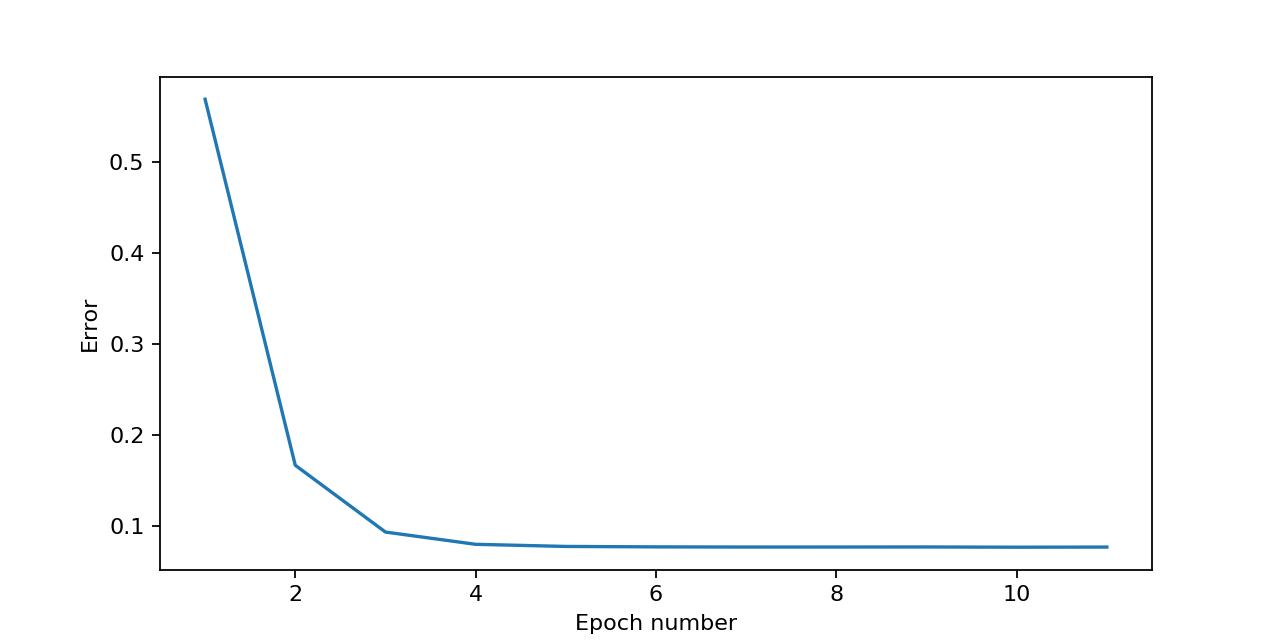

Text(0,0.5,'Error')

In [20]:
# 开始训练
import logging

# Seed a random number generator
seed = 27092016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the CCPP training set
train_data = CCPPDataProvider('train', [0, 1], batch_size=100, rng=rng)
input_dim, output_dim = 2, 1

# Create a parameter initialiser which will sample random uniform values
# from [-0.1, 0.1]
param_init = UniformInit(-0.1, 0.1, rng=rng)

# Create our single layer model
layer = AffineLayer(input_dim, output_dim, param_init, param_init) # weight和biase的维度一致
model = SingleLayerModel(layer)

# Initialise the error object
error = SumOfSquaredDiffsError()

# Use a basic gradient descent learning rule with a small learning rate
learning_rule = GradientDescentLearningRule(learning_rate=1e-2)

# Use the created objects to initialise a new Optimiser instance.

optimiser = Optimiser(model, error, learning_rule, train_data)

# Run the optimiser for 10 epochs (full passes through the training set)
# printing statistics every epoch.
#### note，请注意这里才是在进行训练，请仔细阅读训练的代码
stats, keys, _ = optimiser.train(num_epochs=10, stats_interval=1)

# Plot the change in the error over training.
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(np.arange(1, stats.shape[0] + 1), stats[:, keys['error(train)']])
ax.set_xlabel('Epoch number')
ax.set_ylabel('Error')